# EECS 442 FINAL: Geoguessr Neural Network

## Setup

In [ ]:
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
!pip install torchsummary

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import math
import torch.nn as nn
import torchvision.models as models

In [ ]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the GPU. You are good to go!


## Loading Dataset
Mount the cwd to drive, access the train folder and load the images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# !pip install gitpython > /dev/null 2>&1
# !apt-get install -y -qq git > /dev/null 2>&1

import os
import glob
import random
from PIL import Image


# print(os.getcwd())
# ! ls
# ! cd drive/MyDrive/442final
# print(os.getcwd())

data_directory = "/drive/MyDrive/442final/train/resized_countries_reshape"

batch_size = 32
img_width = 148
img_height = 64
epochs = 30

img_target_scale = 0.2
img_target_width = int(math.floor(img_width * img_target_scale))
img_target_height= int(math.floor(img_height * img_target_scale))

class get_Images(Dataset):
  def __init__(self, root_dir, split='train', percentage=0.7, transform=None):
    """
    Args:
        root_dir: the directory of the dataset
        split: "train" or "val"
        transform: pytorch transformations.
    """
    self.files = []
    self.labels = []

    # if split=='val':
    #   percentage = 1 - percentage

    self.transform = transform
    print(root_dir)
    for idx, country in enumerate(os.listdir(root_dir)):
      print(idx, end=' ')
      # Check if the item is a directory
      files_in_dir = np.load(root_dir+'/'+country).astype(np.float32)
      # print(files_in_dir.dtype)
      # Randomly sample a certain percentage of files
      num_files_to_take = int(len(files_in_dir) * percentage)
      # Append the sampled file paths to the list
      if split=='train':
        self.files.extend(files_in_dir[:num_files_to_take])
      else:
        num_files = len(files_in_dir)
        self.files.extend(files_in_dir[num_files - num_files_to_take:])

      # self.files.extend(glob.glob(os.path.join(root_dir, country, '*.jpg')))
      self.labels.extend([idx] * num_files_to_take)
    print()
    print(len(self.files))
    print(len(self.labels))
  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    # img_path = self.files[idx]
    label = self.labels[idx]
    # img = Image.open(img_path)
    # if self.transform:
    #     img = self.transform(img)
    return {'image': self.files[idx], 'label': label}

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

###########################################################################
# TODO: Construct the dataloader                                          #
# For the train_loader, please use a batch size of 4 and set shuffle True #
# For the val_loader, please use a batch size of 5 and set shuffle False  #
# Hint: You'll need to create instances of the class above, name them as  #
# tr_dt and te_dt. The dataloaders should be named as train_loader and    #
# test_loader. You also need to include transform in your class           #
#instances                                                                #
###########################################################################

tr_dt = get_Images(os.getcwd() + data_directory, split='train', percentage=0.7,  transform=transform)
te_dt = get_Images(os.getcwd() + data_directory, split='val', percentage=0.2, transform=transform)

print("train")
train_loader = DataLoader(tr_dt, batch_size=32, shuffle=True)
print("test")
test_loader = DataLoader(te_dt, batch_size=32, shuffle=False)

###########################################################################
#                              END OF YOUR CODE                           #
###########################################################################

# print('Number of training images {}, number of testing images {}'.format(len(tr_dt), len(te_dt)))

print("Done!")

Mounted at /content/drive
/content/drive/MyDrive/442final/train/resized_countries_reshape
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 
25160
25160
/content/drive/MyDrive/442final/train/resized_countries_reshape
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 
7171
7171
train
test
Done!


## Model
CHANGE THIS TO GET THE MODEL TO RUN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pre-trained DenseNet121
        self.densenet = models.densenet121(pretrained=True)
        # Freeze all layers
        for param in self.densenet.parameters():
            param.requires_grad = True
        # Extract the first n layers
        self.features = nn.Sequential(
            #----------------I CHANGED THIS-----------------------
            # *list(self.densenet.features.children())[:60],
            # visualize
            #-----------------------------------------------------
            nn.Conv2d(1024, 1024, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, 3, 2, 1),
            nn.ReLU()
            )

        self.fc = nn.Linear(1024, 55)
    def forward(self, x):
      # print(f"1{x.size()}")
      x = self.features(x)
      # print(f"2{x.size()}")
      x = x.view(x.size(0), -1)
      # print(f"3{x.size()}")

      x = self.fc(x)
      # print(f"4{x.size()}")
      return x

# Instantiate the model
model = Network()

# Set up optimization hyperparameters

#----------------I CHANGED THIS-----------------------
learning_rate, weight_decay, num_epoch = 0.00001, 1e-14, 10
#-----------------------------------------------------
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

# Specify the loss function
criterion = nn.CrossEntropyLoss()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model architecture
print(model)


Network(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

Run the cell below to start your training, we expect you to achieve over **85%** on the test set. A valid solution that meet the requirement take no more than **10 minutes** on normal PC Intel core CPU setting. If your solution takes too long to train, try to simplify your model or reduce the number of epochs.

In [ ]:
!pip install torchview
from torchview import draw_graph
model_graph = draw_graph(Network(), input_size=(32,3,64,148), graph_dir='LR',save_graph=True,filename="vis",hide_module_functions=True,depth=2)
model_graph.visual_graph

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchview import draw_graph
model1 = AutoModel.from_pretrained("bert-base-uncased")

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

inputs = tokenizer("Hello world!", return_tensors="pt")

model_graph = draw_graph(model1, input_data=inputs)

model_graph.visual_graph


In [ ]:
%%time
def train(model, trainloader, valloader, num_epoch=10):  # Train the model
    print("Start training...")
    trn_loss_hist = []
    trn_acc1_hist = []
    trn_acck_hist = []
    val_acc1_hist = []
    val_acck_hist = []
    model.train()  # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        print('-----------------Epoch = %d-----------------' % (i+1))
        # print(len(tqdm(trainloader)))
        # for i in tqdm(trainloader):
        #   print(i)
        for input in tqdm(trainloader):
            # print(batch, label)
            # print(batch)
            batch, label = input['image'], input['label']
            # print(batch)
            # print(label)
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            # This will call Network.forward() that you implement
            pred = model(batch)
            loss = criterion(pred, label)  # Calculate the loss
            running_loss.append(loss.item())
            loss.backward()  # Backprop gradients to all tensors in the network
            optimizer.step()  # Update trainable weights
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        # Keep track of training loss, accuracy, and validation loss
        trn_loss_hist.append(np.mean(running_loss))
        acc1, acck = evaluate(model, trainloader)
        trn_acc1_hist.append(acc1)
        trn_acck_hist.append(acck)
        print("\n Evaluate on validation set...")
        acc1, acck = evaluate(model, valloader)
        val_acc1_hist.append(acc1)
        val_acck_hist.append(acck)
    print("Done!")
    return trn_loss_hist, trn_acc1_hist, trn_acck_hist, val_acc1_hist, val_acck_hist


def evaluate(model, loader):  # Evaluate accuracy on validation / test set
    model.eval()  # Set the model to evaluation mode
    correct1 = 0
    correctk = 0
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for input in tqdm(loader):
            batch, label = input['image'], input['label']
            batch = batch.to(device)
            label = label.to(device)
            # print(label)
            pred = model(batch)
            _,idx = torch.topk(pred,5)
            # print(label.size())
            # print(idx.size())
            correct1 += (torch.argmax(pred, dim=1) == label).sum().item()
            correctk += (idx == label.unsqueeze(-1)).sum().item()
        acc1 = correct1/len(loader.dataset)
        acck = correctk/len(loader.dataset)
        print(f"\n Evaluation accuracy: top1 {acc1}, topk {acck}")
        model.train()
        return acc1, acck


trn_loss_hist, trn_acc1_hist, trn_acck_hist, val_acc1_hist, val_acck_hist = train(model, train_loader,
                                                  test_loader, num_epoch)

##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
# evaluate(model, testloader)

Start training...
-----------------Epoch = 1-----------------


100%|██████████| 787/787 [01:46<00:00,  7.40it/s]



 Epoch 1 loss:3.494009587180054


100%|██████████| 787/787 [00:21<00:00, 37.45it/s]



 Evaluation accuracy: top1 0.1759141494435612, topk 0.4300476947535771

 Evaluate on validation set...


100%|██████████| 225/225 [00:06<00:00, 34.46it/s]



 Evaluation accuracy: top1 0.17110584297866407, topk 0.42797378329382235
-----------------Epoch = 2-----------------


100%|██████████| 787/787 [01:45<00:00,  7.44it/s]



 Epoch 2 loss:3.1315824237227288


100%|██████████| 787/787 [00:20<00:00, 37.54it/s]



 Evaluation accuracy: top1 0.28231319554848966, topk 0.562758346581876

 Evaluate on validation set...


100%|██████████| 225/225 [00:06<00:00, 36.89it/s]



 Evaluation accuracy: top1 0.23553200390461582, topk 0.5300515967089666
-----------------Epoch = 3-----------------


100%|██████████| 787/787 [01:45<00:00,  7.45it/s]



 Epoch 3 loss:2.710545038328692


100%|██████████| 787/787 [00:20<00:00, 37.55it/s]



 Evaluation accuracy: top1 0.3686804451510334, topk 0.6625993640699523

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 40.02it/s]



 Evaluation accuracy: top1 0.280016734067773, topk 0.5916887463394227
-----------------Epoch = 4-----------------


100%|██████████| 787/787 [01:45<00:00,  7.43it/s]



 Epoch 4 loss:2.3639647521391


100%|██████████| 787/787 [00:21<00:00, 36.30it/s]



 Evaluation accuracy: top1 0.4575914149443561, topk 0.7399443561208268

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 38.95it/s]



 Evaluation accuracy: top1 0.29256728489750383, topk 0.610514572584019
-----------------Epoch = 5-----------------


100%|██████████| 787/787 [01:46<00:00,  7.41it/s]



 Epoch 5 loss:2.0819615393763424


100%|██████████| 787/787 [00:21<00:00, 37.15it/s]



 Evaluation accuracy: top1 0.514745627980922, topk 0.7929252782193958

 Evaluate on validation set...


100%|██████████| 225/225 [00:06<00:00, 33.74it/s]



 Evaluation accuracy: top1 0.29898201087714404, topk 0.6169292985636592
-----------------Epoch = 6-----------------


100%|██████████| 787/787 [01:46<00:00,  7.39it/s]



 Epoch 6 loss:1.824035183447289


100%|██████████| 787/787 [00:21<00:00, 35.94it/s]



 Evaluation accuracy: top1 0.5931240063593005, topk 0.8403418124006359

 Evaluate on validation set...


100%|██████████| 225/225 [00:06<00:00, 36.01it/s]



 Evaluation accuracy: top1 0.3037233300794868, topk 0.6039603960396039
-----------------Epoch = 7-----------------


 87%|████████▋ | 684/787 [01:32<00:13,  7.37it/s]


KeyboardInterrupt: 

Once your training is complete, run the cell below to visualize the training and validation accuracies across iterations.

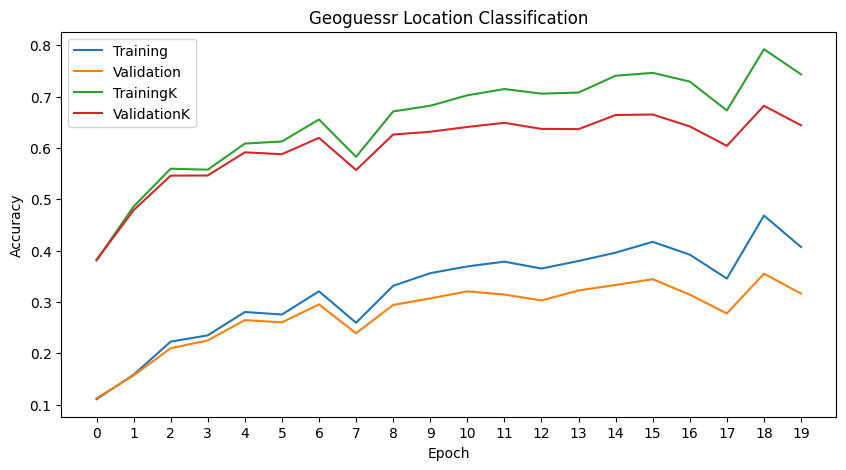

In [ ]:
##############################################################################
# TODO: Submit the accuracy plot                                             #
##############################################################################
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc1_hist)
plt.plot(x, val_acc1_hist)
plt.plot(x, trn_acck_hist)
plt.plot(x, val_acck_hist)
plt.legend(['Training', 'Validation', 'TrainingK','ValidationK'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Geoguessr Location Classification')
plt.gcf().set_size_inches(10, 5)
plt.savefig('part1.png', dpi=300)
plt.show()

# @half a page of results

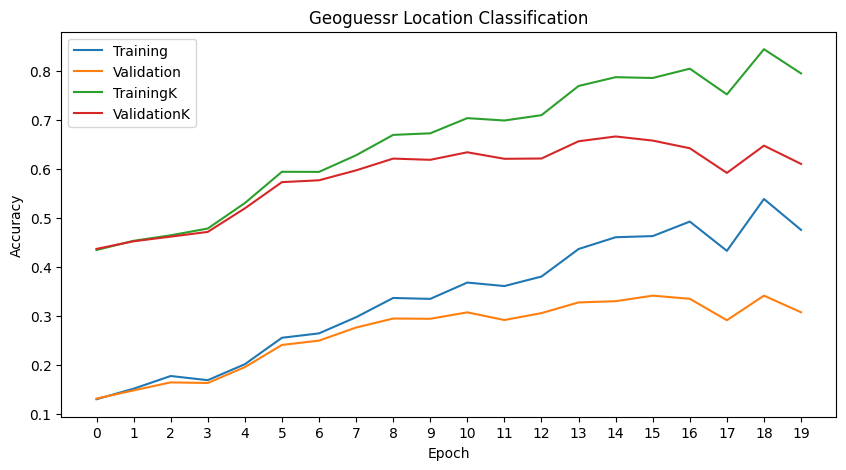

In [ ]:
##############################################################################
# TODO: Submit the accuracy plot                                             #
##############################################################################
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc1_hist)
plt.plot(x, val_acc1_hist)
plt.plot(x, trn_acck_hist)
plt.plot(x, val_acck_hist)
plt.legend(['Training', 'Validation', 'TrainingK','ValidationK'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Geoguessr Location Classification')
plt.gcf().set_size_inches(10, 5)
plt.savefig('part1.png', dpi=300)
plt.show()

In [ ]:
!pip install umap-learn

import numpy as np
import umap  # Import UMAP from umap.umap_ module
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
images = np.array(te_dt)  # Convert to numpy array

images_data = []
labels = []
for i in images:
  images_data.append(i['image'])
  labels.append(i['label'])
del te_dt
del images
# Convert images_data to numpy array
images_array = np.array(images_data)

# Flatten the images and normalize
num_images = len(images_array)
image_shape = images_array[0].shape
X = images_array.reshape(num_images, -1).astype(float)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=3)
embedding = umap_model.fit_transform(X_scaled)

# # Plot the embeddings, color-coded by labels
# plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=0.1)
# plt.title('UMAP Visualization')
# plt.colorbar()
# plt.show()


NameError: name 'te_dt' is not defined

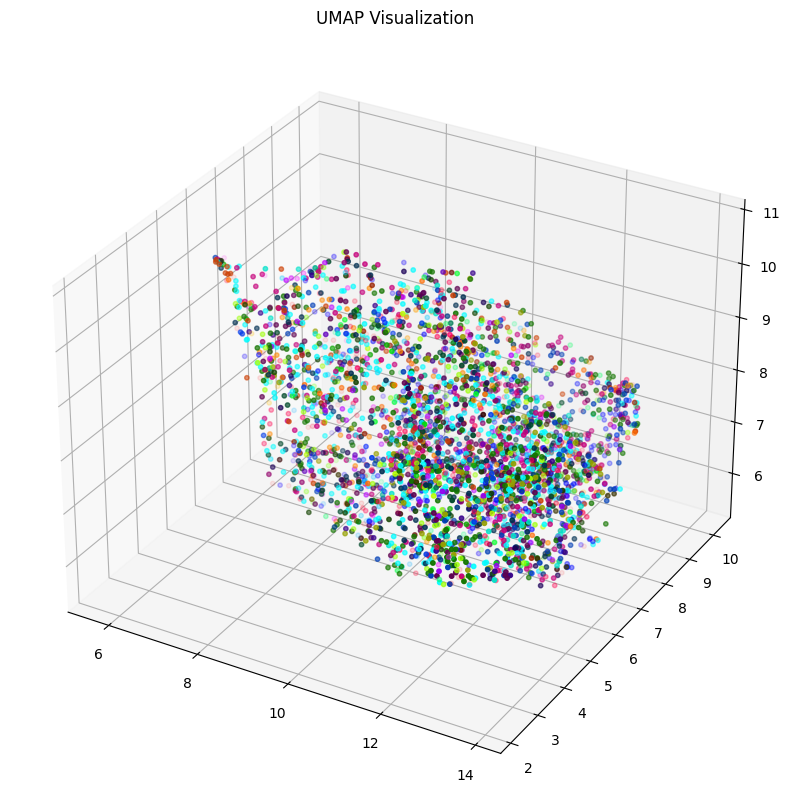

In [ ]:
import matplotlib
from matplotlib.colors import ListedColormap
def generate_colormap(N):
    arr = np.arange(N)/N
    N_up = int(math.ceil(N/7)*7)
    arr.resize(N_up)
    arr = arr.reshape(7,N_up//7).T.reshape(-1)
    ret = matplotlib.cm.hsv(arr)
    n = ret[:,3].size
    a = n//2
    b = n-a
    for i in range(3):
        ret[0:n//2,i] *= np.arange(0.2,1,0.8/a)
    ret[n//2:,3] *= np.arange(1,0.1,-0.9/b)
#     print(ret)
    return ret

unique_labels = np.unique(labels)
num_categories = len(unique_labels)
color_map = plt.get_cmap('hsv', num_categories)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=labels, cmap=ListedColormap(generate_colormap(55)), s=10)  # Increase the size of points
ax.set_title('UMAP Visualization')

plt.show()

# # For 3D visualization
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# for i, label in enumerate(unique_labels):
#     indices = np.where(labels == label)[0]
#     ax.scatter(embedding[indices, 0], embedding[indices, 1], embedding[indices, 2], c=color_map(i), label=label, s=10)  # Assign specific color for each category
# ax.set_title('UMAP Visualization')
# ax.legend(title='Category')
# plt.show()